In [2]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from numba import jit
%matplotlib inline

# Hamiltonian Dynamics, Statistical Mechanics, and Monte-Carlo Methods

## Hamiltonian Systems

Given a scalar function $H:\mathbb{R}^{2n}\rightarrow \mathbb{R}$ where $H = H({\bf q},{\bf p})$, we are interested in studying the affiliated dynamical system generated by the differential equations

$$
\dot{q}_{j} = \frac{\partial H}{\partial p_{j}}, ~ \dot{p}_{j} = -\frac{\partial H}{\partial q_{j}}
$$

which we abbreviate via the expression 

$$
\frac{d}{dt}\begin{pmatrix} {\bf q}\\ {\bf p} \end{pmatrix} = J \begin{pmatrix}\nabla_{{\bf q}}H \\ \nabla_{{\bf p}}H \end{pmatrix}, ~ J = \begin{pmatrix} 0 & -I \\ I & 0 \end{pmatrix}
$$

### The Poisson Bracket and Conserved Quantities

For a quantity $C(t)$ which _follows the flow_ so that $C(t) = C({\bf q}(t),{\bf p}(t))$, we readily see using the standard chain rule from multivariable Calculus that 

$$
\dot{C} = \sum_{j=1}^{n}\left(\frac{\partial C}{\partial q_{j}}\frac{\partial H}{\partial p_{j}} - \frac{\partial C}{\partial p_{j}}\frac{\partial H}{\partial q_{j}}  \right).
$$

To abbreviate this result, we introduce the _Poissson bracket_ $\left\{\cdot,\cdot\right\}$ where for sufficiently smooth functions $A,B:\mathbb{R}^{2n}\rightarrow \mathbb{R}$ we have 

$$
\left\{A,B\right\} = \sum_{j=1}^{n}\left(\frac{\partial A}{\partial q_{j}}\frac{\partial B}{\partial p_{j}} - \frac{\partial A}{\partial p_{j}}\frac{\partial B}{\partial q_{j}}  \right).
$$

Thus the above dynamical expression can now be written in the form

$$
\dot{C} = \left\{C,H\right\},
$$

encapsulating a central idea in Hamiltonian dynamics which is that all dynamical quantities are _generated by the bracket_.  To wit, we readily see that 

$$
\dot{q}_{j} = \left\{q_{j},H\right\}, ~ \dot{p}_{j} = \left\{p_{j},H\right\}.
$$

Moreover, we can show that 

* $\left\{A,B\right\} = -\left\{B,A\right\}$
* $\left\{c_{1}A_{1}+c_{2}A_{2},B\right\} = c_{1}\left\{A_{1},B\right\}+c_{2}\left\{A_{2},B\right\}$
* $\left\{\left\{A,B\right\},C\right\}+\left\{\left\{B,C\right\},A\right\}+\left\{\left\{C,A\right\},B\right\}=0$

From these properties, we see that $\dot{H} = \left\{H,H\right\} = -\left\{H,H\right\} = 0$, so the Hamiltonian itself is always conserved.  Likewise any other conserved quantity $I$ must necessarily satisfy $\left\{I,H\right\}=0$, so that we now have an algebraic requirement for quantities to be preserved by Hamiltonian flows.  

## Liouville's Theorem and Ensembles

## A Fast Introduction to Markov Chains

## Realizing an Equilibrium Distribution Via a Markov Chain: Monte Carlo Methods

## Point-Vortex Models



In [3]:
# These subroutines allow us to use RK4 to time-step vortices forward
def pvrtx_rhs(Zpos,Gvls):
    hZpos = np.matlib.repmat(Zpos,Nv,1)
    vZpos = np.matlib.repmat(np.vstack(Zpos),1,Nv)
    imat = np.identity(Zpos.size)
    Zdif = np.conj(1./(hZpos-vZpos + imat)-imat)
    return -1j/(2.*np.pi)*np.matmul(Zdif,Gvls)

def rk4(f,Zpos,Gvls,dt):
    k1 = f(Zpos,Gvls)
    k2 = f(Zpos+dt*k1/2.,Gvls)
    k3 = f(Zpos+dt*k2/2.,Gvls)
    k4 = f(Zpos+dt*k3,Gvls)
    Zpos += dt*(k1+2.*(k2+k3)+k4)/6.
    return Zpos
    
def tstpr(Zpos,Gvls,dt,tf):
    nstp = np.int(np.round(tf/dt))
    for jj in range(nstp):
        Zpos = rk4(pvrtx_rhs,Zpos,Gvls,dt)
    return Zpos

In [145]:
## Here we start to put all of this into practice 
def hamiltonian(Gvls,Zpos,Nv,lam1,lam2):
    hZpos = np.matlib.repmat(Zpos,Nv,1)
    vZpos = np.matlib.repmat(np.vstack(Zpos),1,Nv)
    Zdif = np.log(np.abs(hZpos - vZpos) + np.identity(Nv))
    G1 = np.matmul(Zdif,Gvls)
    H = np.dot(Gvls,G1)/(2.*np.pi)
    A = np.sum(Gvls*np.real(Zpos*np.conj(Zpos)))
    Tham = lam1*np.real(H) + lam2*A
    return Tham

def hupdt(zc,gc,Zred,Gred,lam1,lam2):
    H = gc*np.dot(Gred,np.log(np.abs(zc-Zred)))/(np.pi)
    A = gc*np.real(zc*np.conj(zc))
    Tham = lam1*np.real(H) + lam2*A
    return Tham

def init_vorts(Ll,Nv):
    Gvls = np.random.uniform(1,5,Nv)
    #Gvlsn = -Gvlsp
    #Gvls = np.concatenate((Gvlsp,Gvlsn))
    Zpos = np.zeros(Nv,dtype=np.complex128)
    dt = 1e-2
    tf = 5.
    nsq = np.int(np.sqrt(Nv))
    xsmesh = np.linspace(-Ll,Ll,nsq)
    Zpos = np.kron(xsmesh,np.ones(nsq)) + 1j*np.kron(np.ones(nsq),xsmesh)
    Zpos = tstpr(Zpos,Gvls,dt,tf)
    return [Gvls,Zpos]

def rwstep(z,dx,dy):
    x = np.real(z)
    y = np.imag(z)
    p = 1./8.
    chc = np.random.uniform(0,1,1)
    if chc < p:
        x -= dx
    elif chc < 2.*p:
        x += dx
    elif chc < 3.*p:
        y -= dy
    elif chc < 4.*p:
        y += dy
    elif chc < 5.*p:
        x -= dx
        y -= dy
    elif chc < 6.*p:
        x -= dx
        y += dy
    elif chc < 7.*p:
        x += dx
        y -= dy
    else:
        x += dx
        y += dy
    zupdt = x + 1j*y
    return zupdt

@jit
def point_vortex_mc(Nm,Nv,Nstp,Ll,lam1,lam2):
    xmesh = np.linspace(-Ll,Ll,Nm+1)
    ymesh = np.linspace(-Ll,Ll,Nm+1)
    dx = 2.*Ll/Nm
    ivals = init_vorts(Ll,Nv)
    Gvls = ivals[0]
    Zpos = ivals[1]
    Zint = np.zeros(Nv,dtype=np.complex128)
    Zint[:] = Zpos
    brnn = np.int(np.round(.25*Nstp))
    cnt = 0
    samps = np.zeros((Nv,Nstp-brnn),dtype=np.complex128)
    for kk in range(Nstp):
        for ll in range(Nv):
            zcnd = rwstep(Zpos[ll],dx,dx)
            Zred = np.concatenate((Zpos[:ll],Zpos[ll+1:]))
            Gred = np.concatenate((Gvls[:ll],Gvls[ll+1:]))
            Hcnd = hupdt(zcnd,Gvls[ll],Zred,Gred,lam1,lam2)
            alpha = np.min(np.array([1.,np.exp(Hcnd)]))
            u = np.random.uniform(0,1,1)
            if alpha >= u:
                Zpos[ll] = zcnd
        if kk>brnn:
            samps[:,cnt] = Zpos
            cnt += 1
    
    colors = Gvls
    
    plt.figure(1,figsize=(6, 6))
    
    plt.subplot(2,1,1)
    plt.scatter(np.real(Zint),np.imag(Zint),c=colors)
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    cbar = plt.colorbar()
    
    plt.subplot(2,1,2)
    plt.scatter(np.real(Zpos),np.imag(Zpos),c=colors)
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    cbar = plt.colorbar()
    
    plt.tight_layout()

In [146]:
Nv = 400
print(-8*np.pi/Nv)

-0.06283185307179587


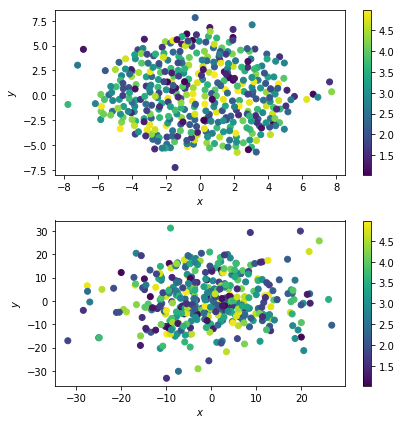

In [153]:
Nm = 100
Nstp = 12800
Ll = 5
lam1 = .05
lam2 = -1e-4
point_vortex_mc(Nm,Nv,Nstp,Ll,lam1,lam2)